## Vehicle Detection Project
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* We apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* We normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

We first read the images of vehicles and non-vehicles into two arrays (cars and not_cars).

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import glob
import matplotlib.pyplot as plt

%matplotlib inline

# Make a list of car images
images = glob.glob('./vehicles/*/*.png')
print('The number of vehicle images:', len(images))

cars = []
# load images into cars array
for fname in images:
    img = mpimg.imread(fname)
    cars.append(img)
    
nc_images = glob.glob('./non-vehicles/*/*.png')
print('The number of non-vehicle images:', len(nc_images))

not_cars = []
# load non-vehicle images into not_cars array
for fname in nc_images:
    img = mpimg.imread(fname)
    not_cars.append(img)
    

The number of vehicle images: 8792
The number of non-vehicle images: 8968


Here we show five random images of cars and not cars:

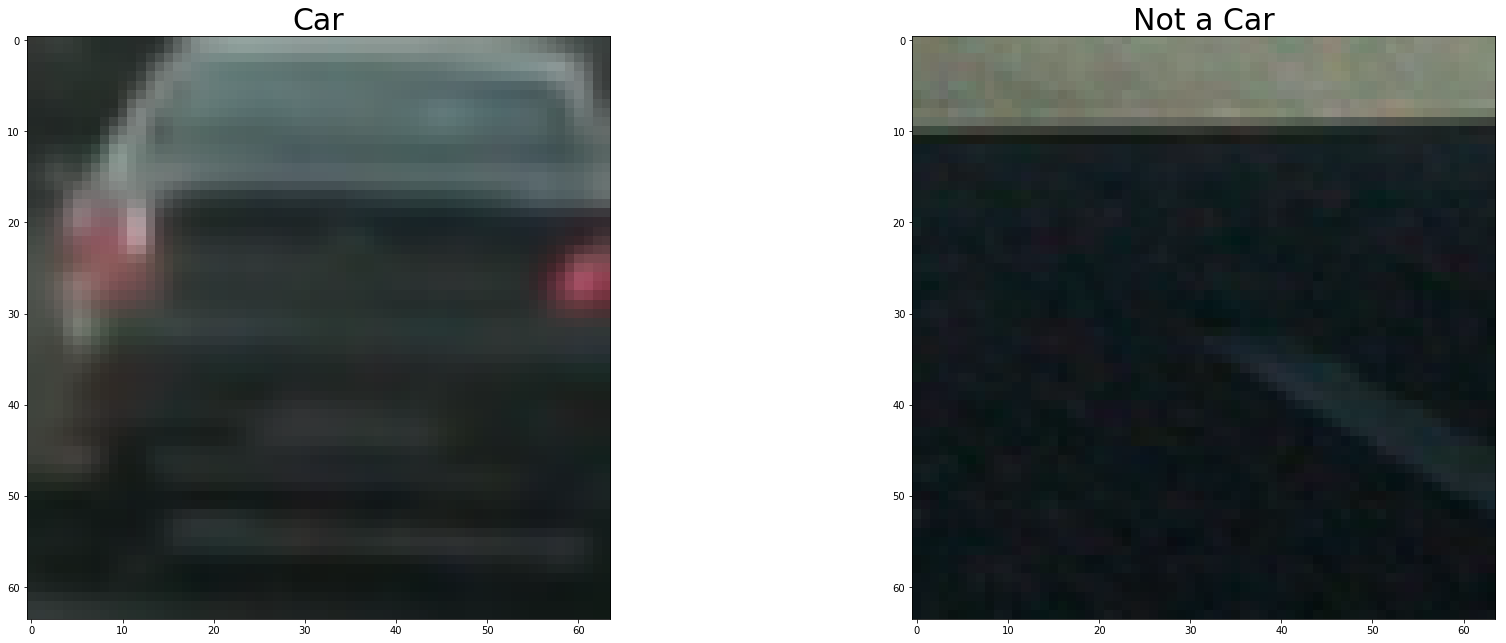

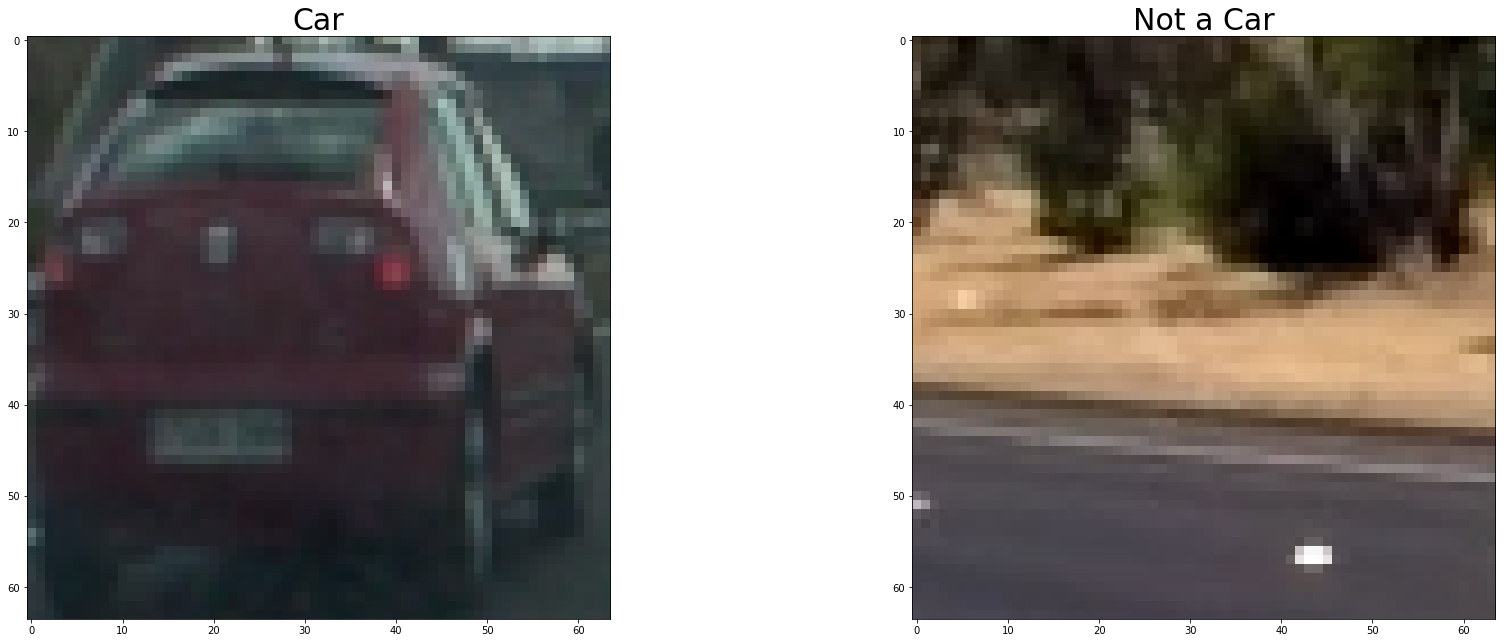

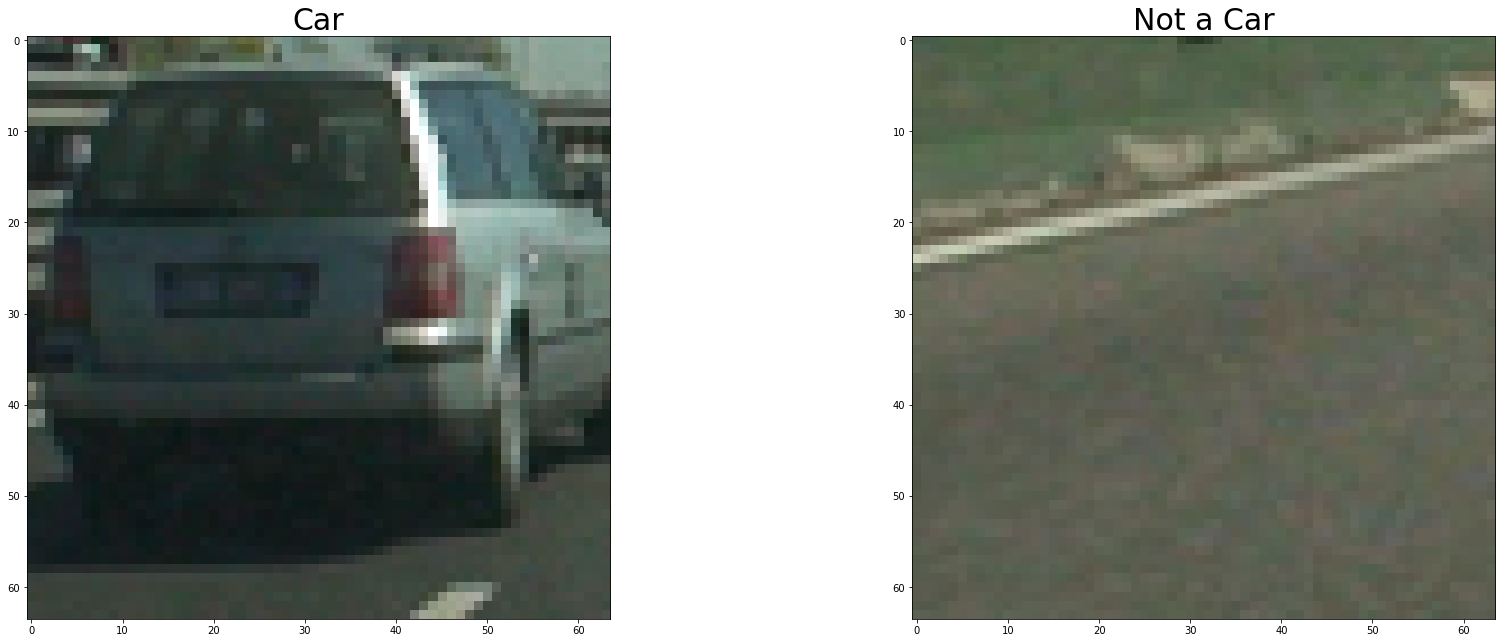

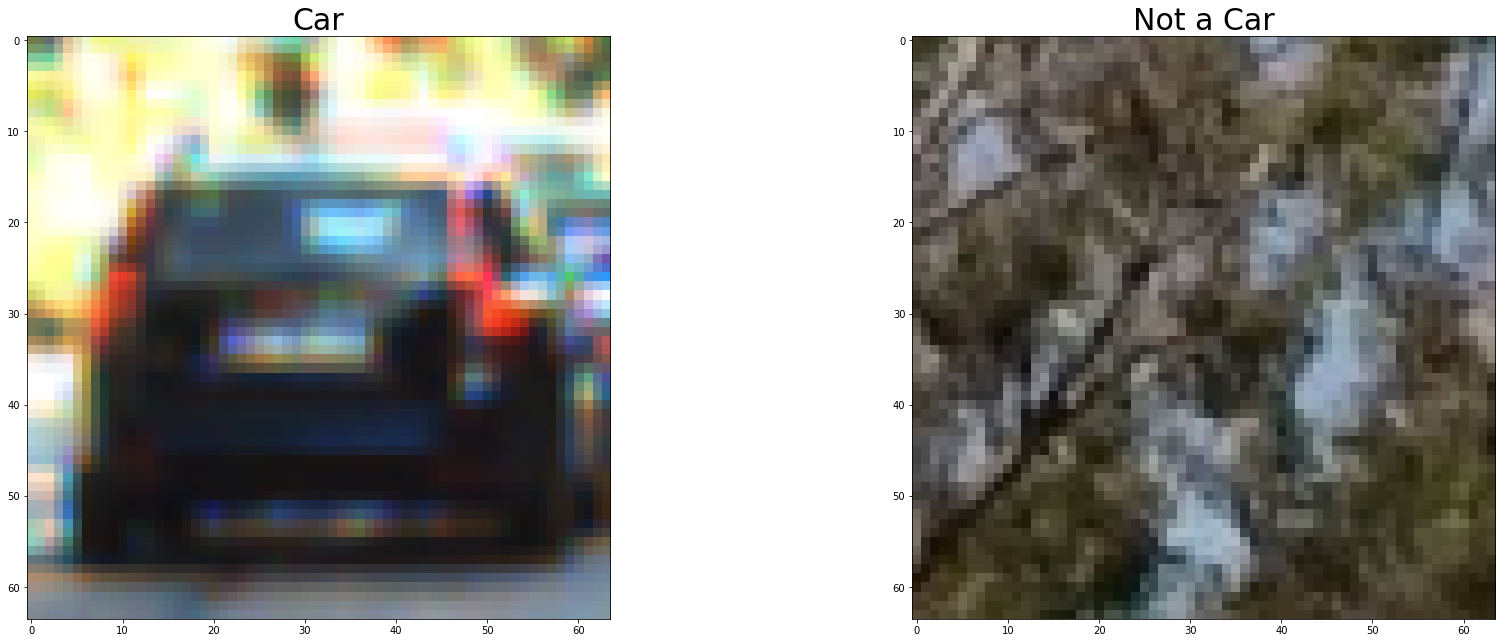

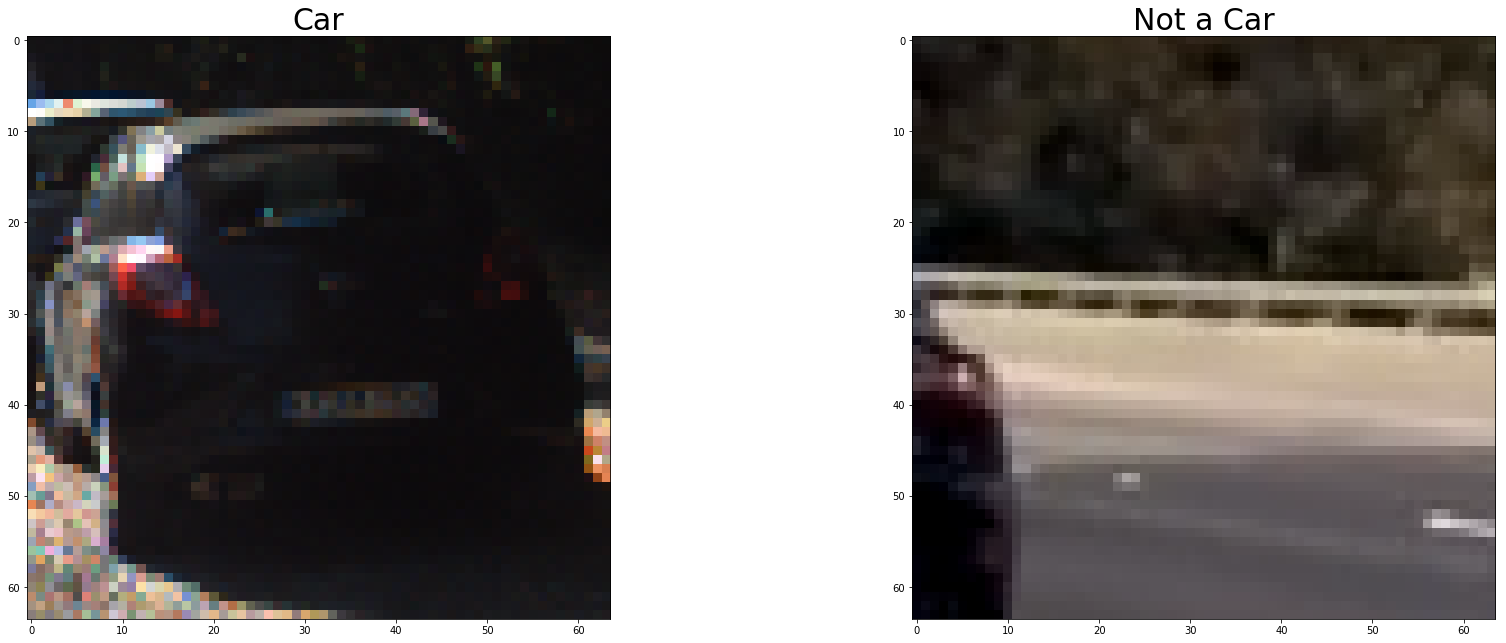

In [4]:
import random

# let's preview a couple for images from datasets
for i in range(5):
    car = random.choice(cars)
    not_car = random.choice(not_cars)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(car)
    ax1.set_title('Car', fontsize=30)
    ax2.imshow(not_car)
    ax2.set_title('Not a Car', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

We how visualize five car images and their corresponding hog features: 

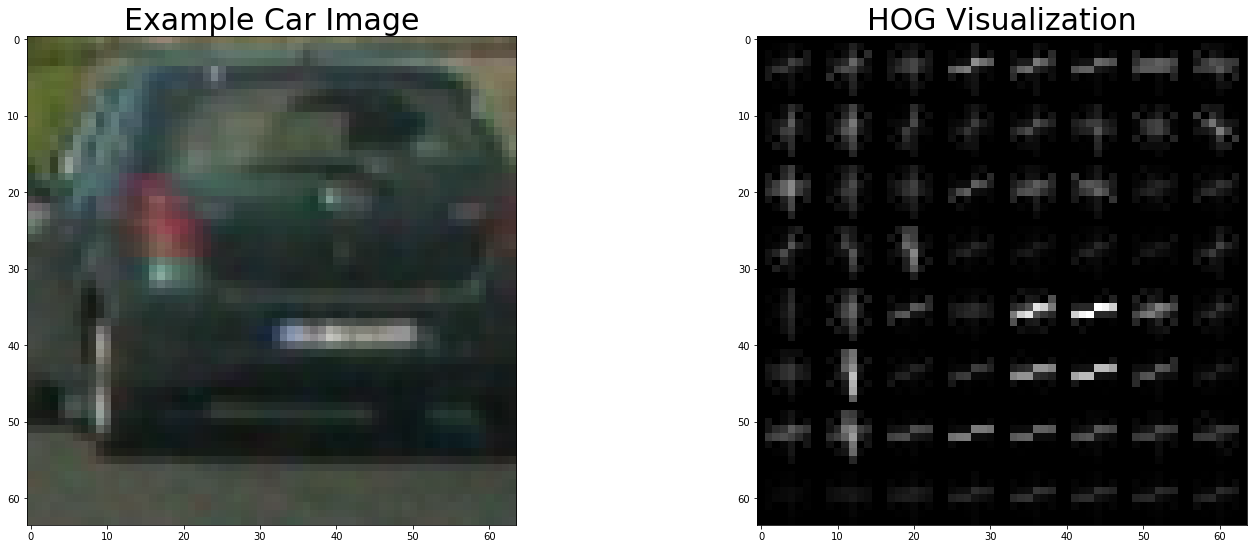

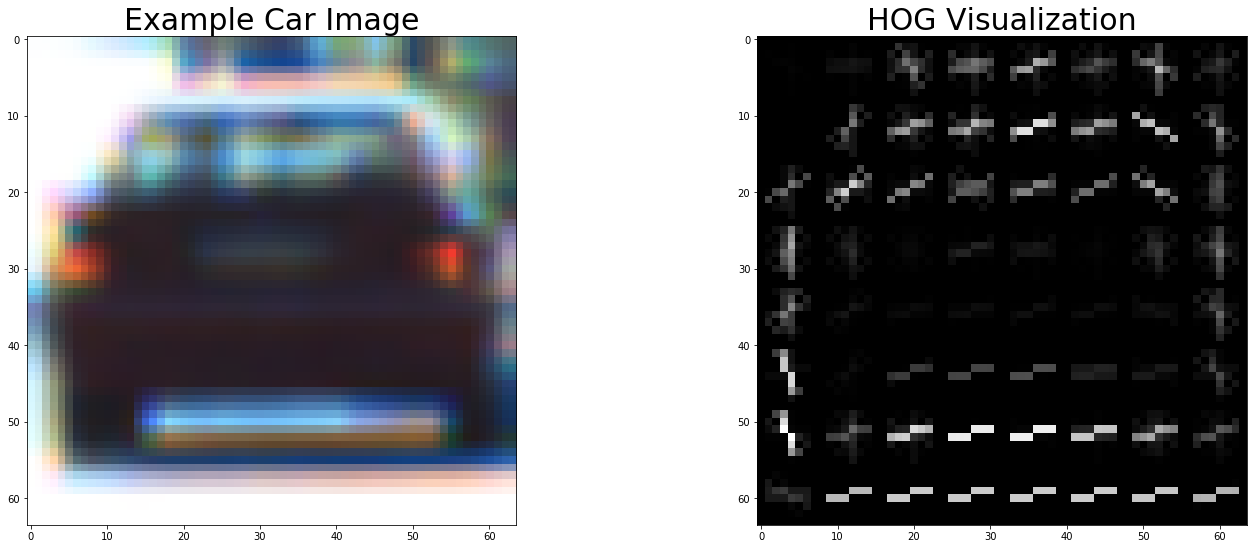

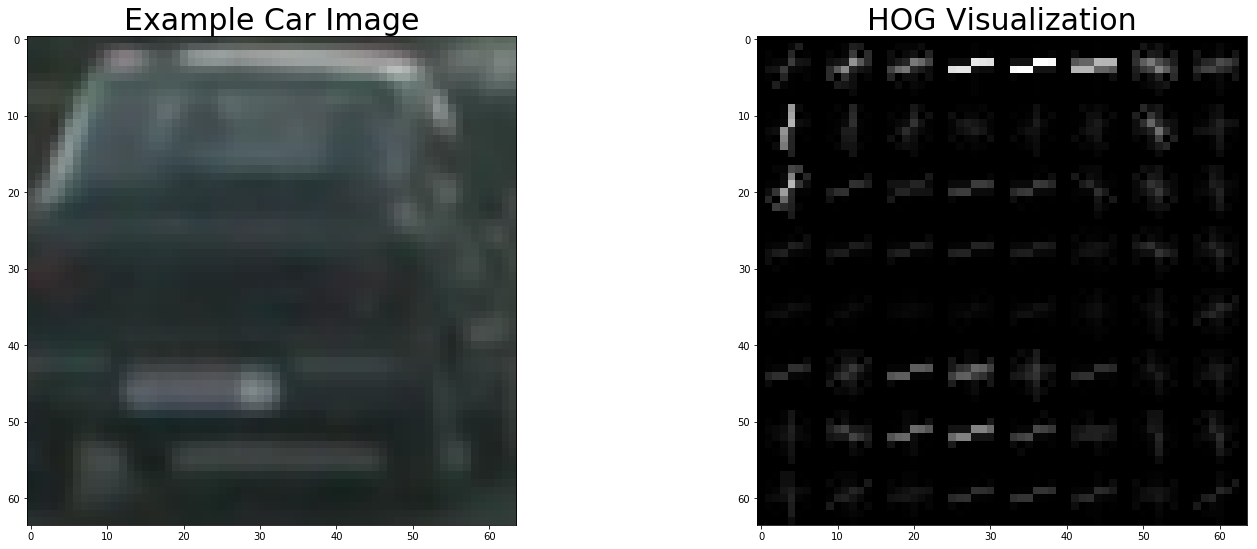

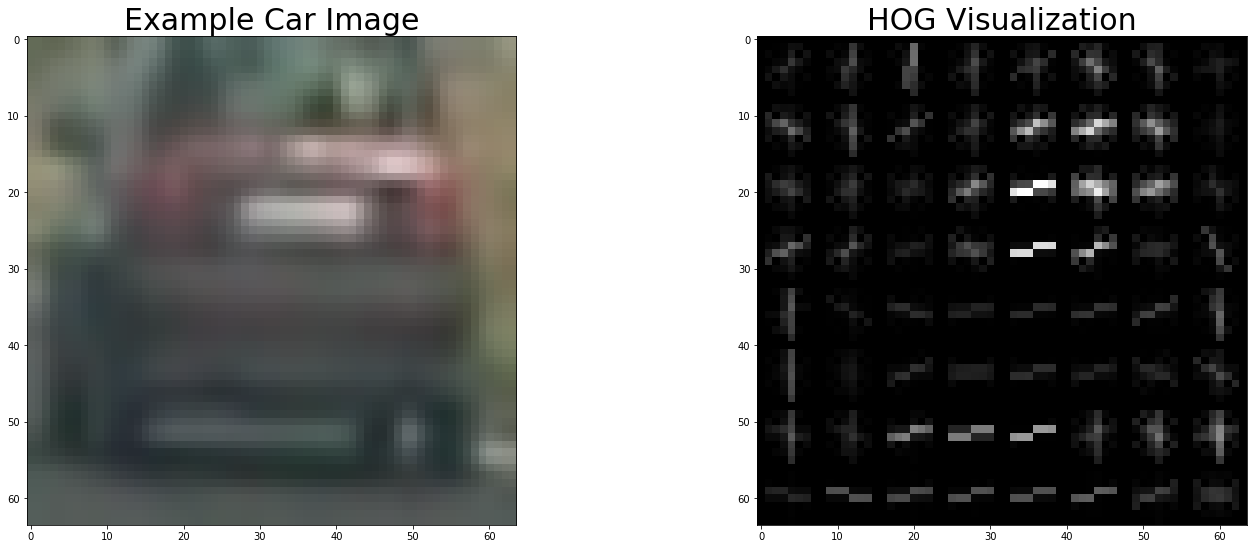

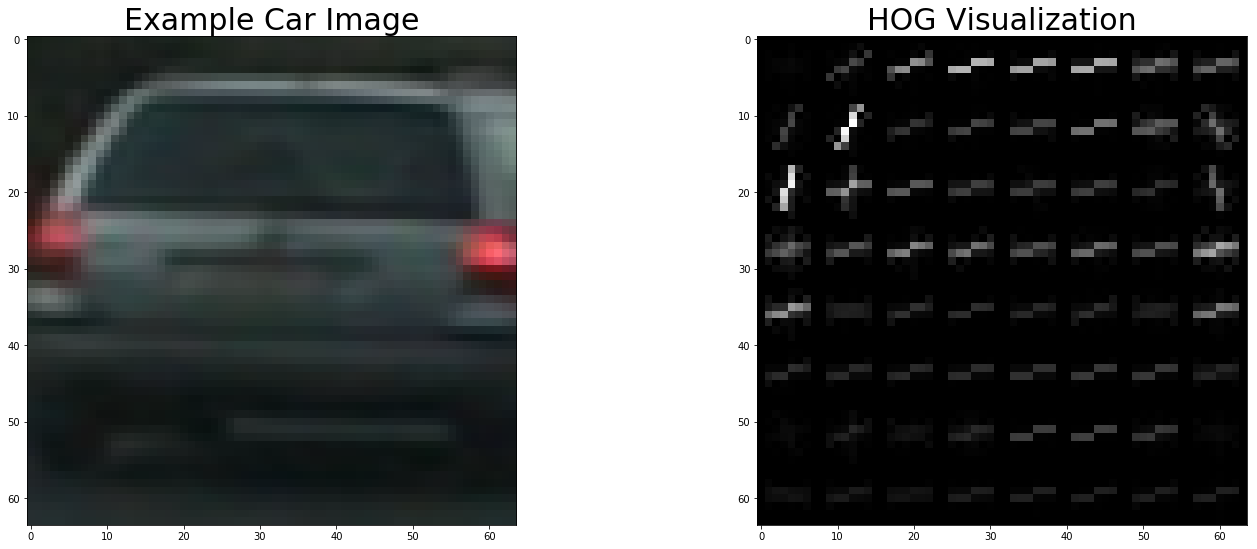

In [6]:
# let's calculate hog features
import numpy as np
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

for i in range(5):
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(cars))
    # Read in the image
    image = cars[ind]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Define HOG parameters
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)


    # Plot the examples
    fig = plt.figure(figsize=(24, 9))
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image', fontsize=30)
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization', fontsize=30)


We now introduce functions for creating spatial and color histogram features and combine them with hog features for an extract_features function

In [9]:
from sklearn.preprocessing import StandardScaler

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


Next we apply feature extraction to array of vehicle images cars and array non-vehicle images not_cars. We use color space YCrCb, 11 HOG orientations, 8 HOG pixels per cell, 2 HOG cells per block and use all the channels of the image to extract HOG features. For spatial features we use 32 by 32 binning dimentions and for color histogram features we use 32 histogram bins. This results in 9636 features. We use Linear Support Vector Classifier to create a classifier with 99.01% accuracy on a test set (20% of our image data).

In [12]:
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(not_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9636
8.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


Initially, we are going to apply our vehicle detection pipeline to the following set of six test images:

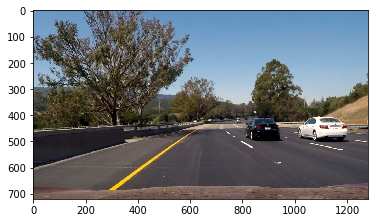

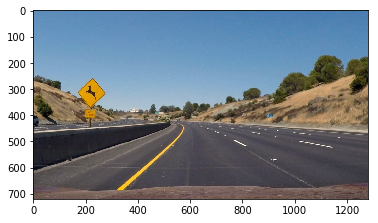

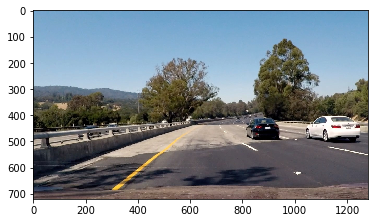

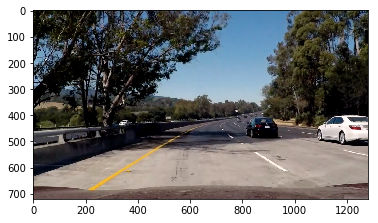

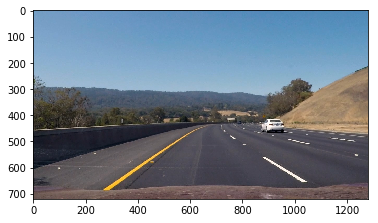

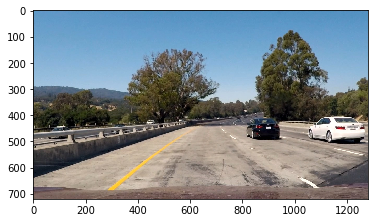

In [13]:
test_images = glob.glob('./test_images/*.jpg')

test_imgs = []
for test_image in test_images:
    img = mpimg.imread(test_image)
    test_imgs.append(img)
    fig = plt.figure()
    plt.imshow(img)

We use the following find_cars function, which, instead of doing a sliding window technique, runs the HOG feature extraction on the whole image (actually a subset delineated by ystart, ystop parameters). 

In [14]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    # make a copy of the image
    draw_img = np.copy(img)
    # scale the image to [0,1]
    img = img.astype(np.float32)/255
    
    # restrict the image search area
    img_tosearch = img[ystart:ystop,:,:]
    # convert the image search area to YCrCb
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    # if scale is not 1 shrink the search area by scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # split the search area into channels    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

We set ystart and ystop parameters in such a way as to exclude the sky and the trees and the hood of the car from our search. We try searching first with a scale parameter of 1.75.

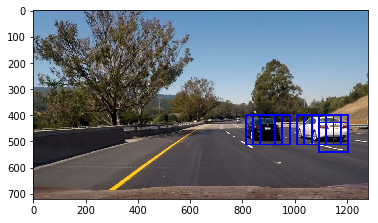

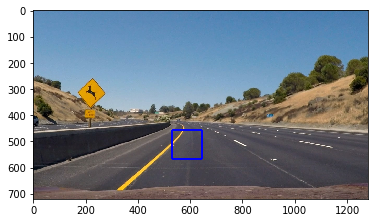

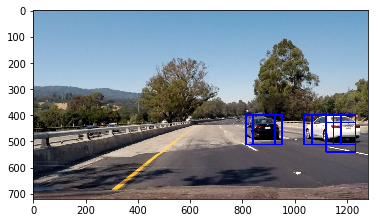

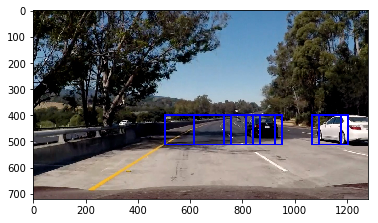

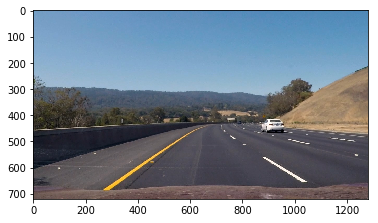

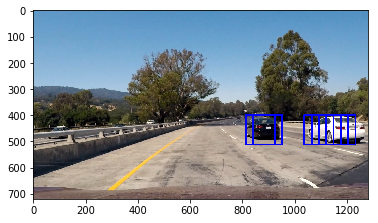

In [15]:
ystart = 400
ystop = 656

scale = 1.75

for img in test_imgs:
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    fig = plt.figure()
    plt.imshow(out_img)

We notice that the car on the 5th image is not found at scale 1.75. In the following sample we reduce the scale to 1.25 and try again. We now notice that we found the car.

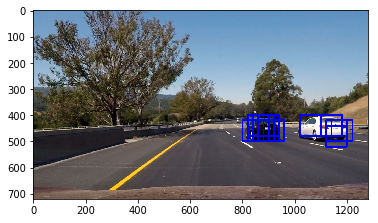

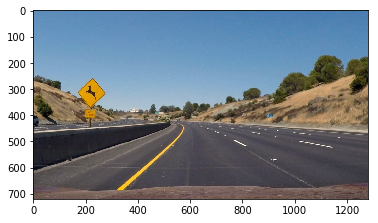

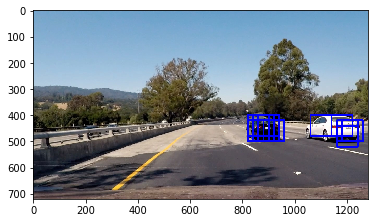

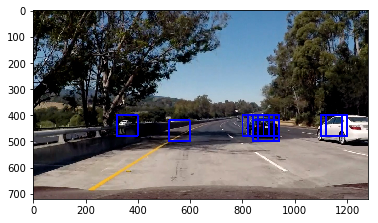

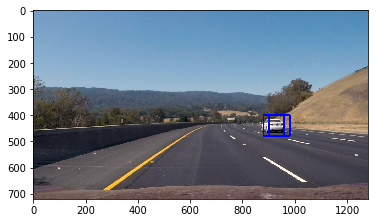

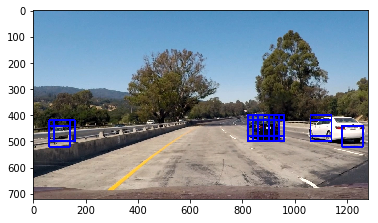

In [17]:
scale = 1.25
for img in test_imgs:
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    fig = plt.figure()
    plt.imshow(out_img)

For our final pipeline we are going to search for the car at four different scales (1.25, 1.5, 1.75, and 2.0). We combine all the boxes using a heatmap technique and set a threshold of 2 for a final bounding box. The results are shown in a set of images below. Even though on the fourth image we see a ghost bounding box, which could be removed by setting the threshold higher, we found that on the actual videos the performance of our pipeline is better with threshold left at 2.

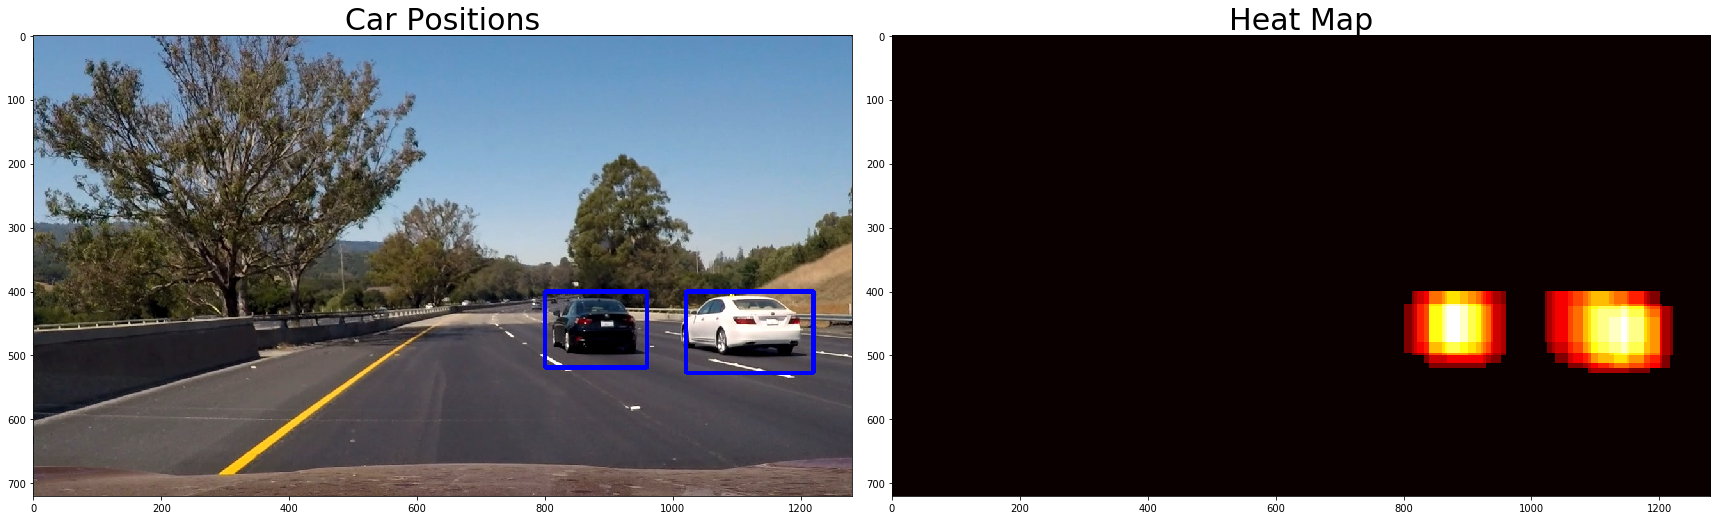

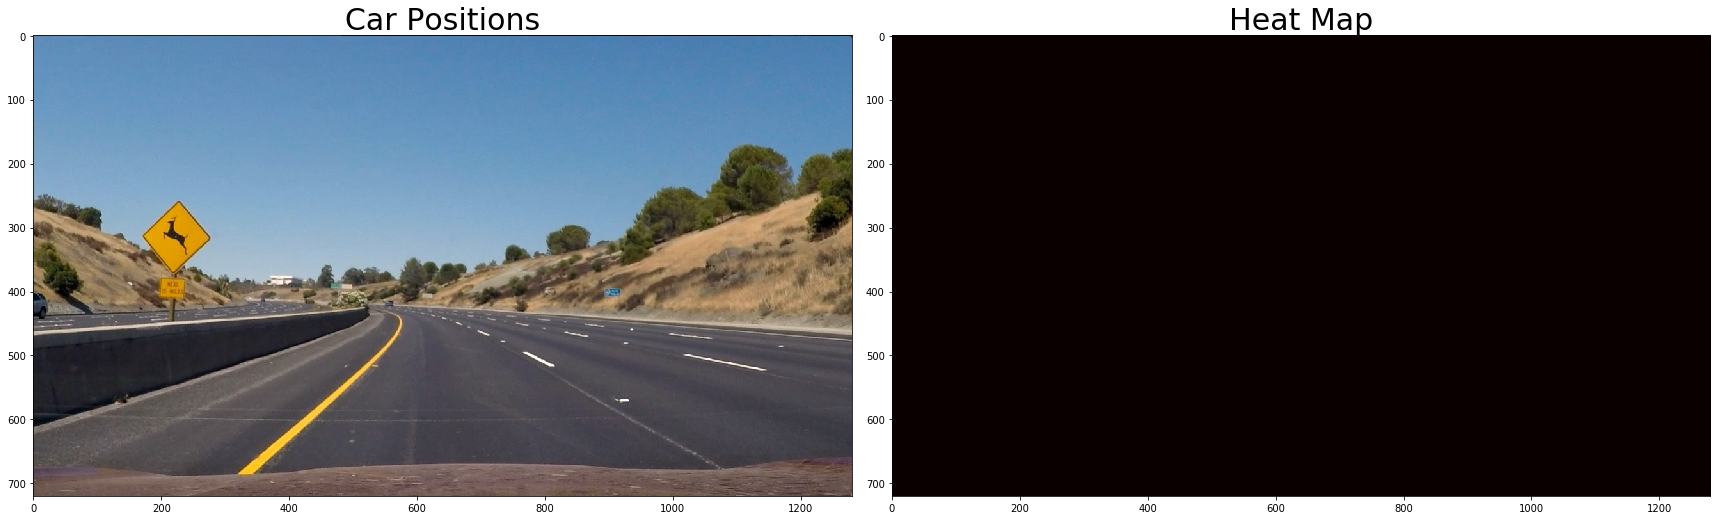

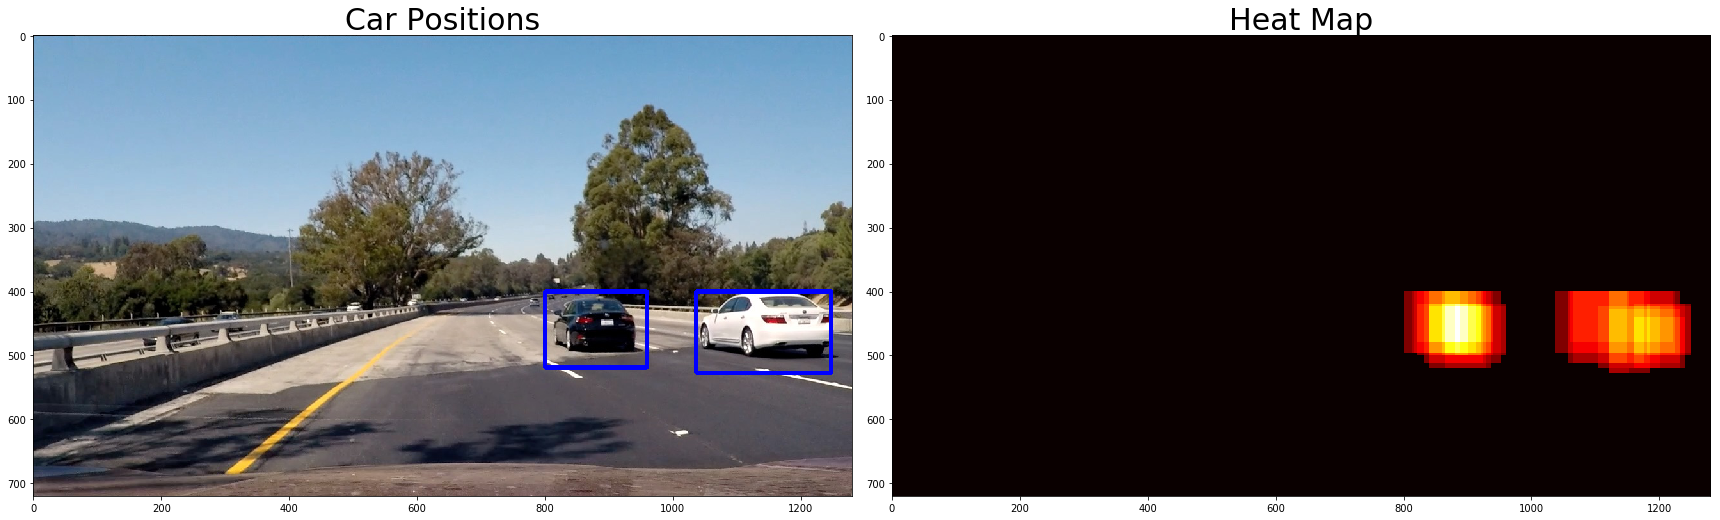

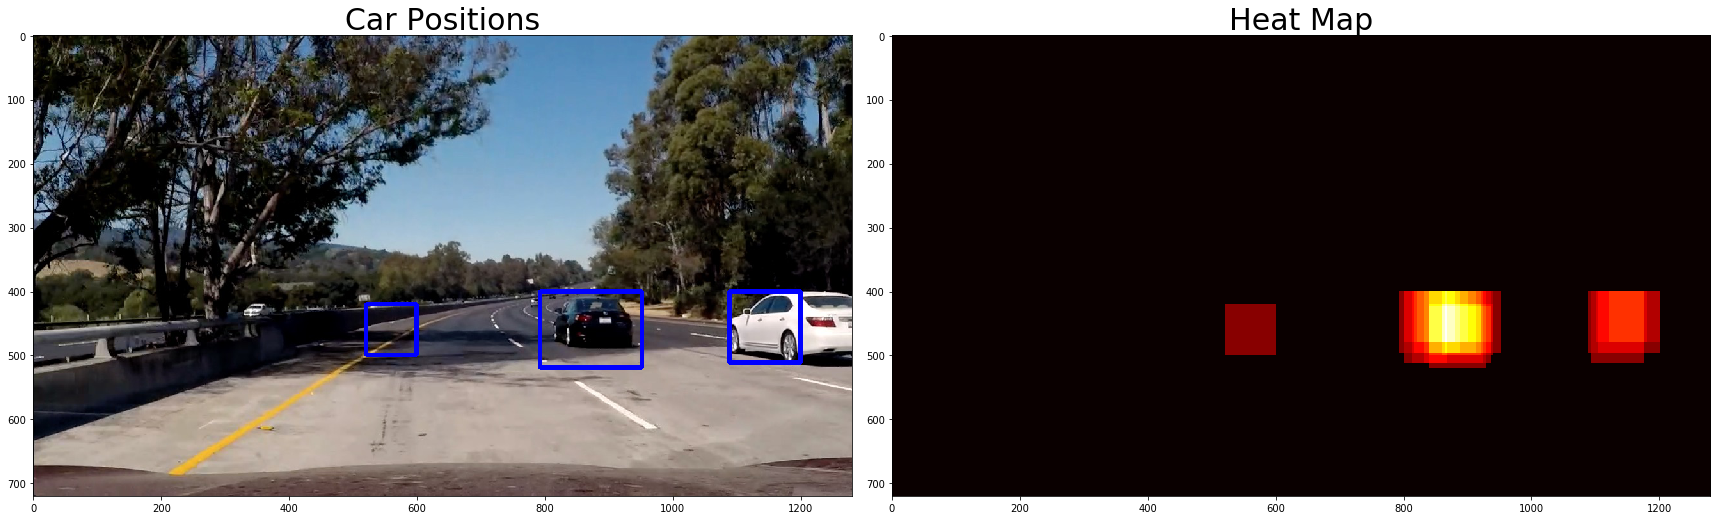

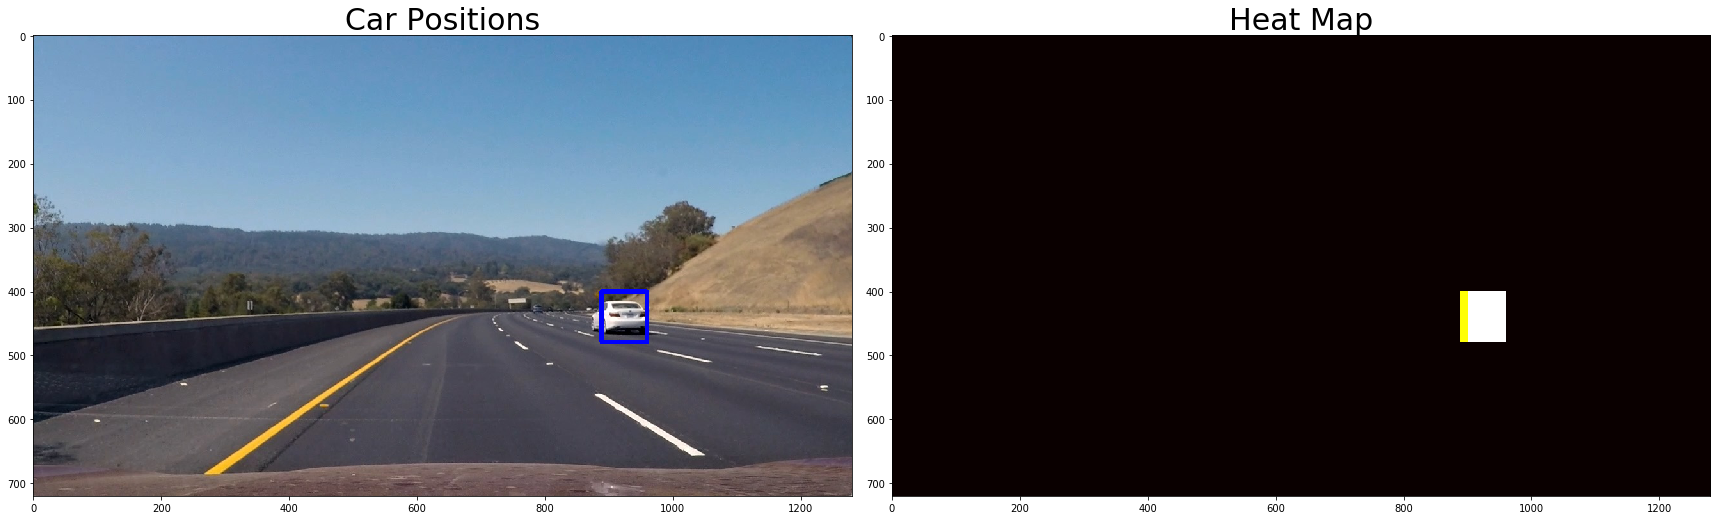

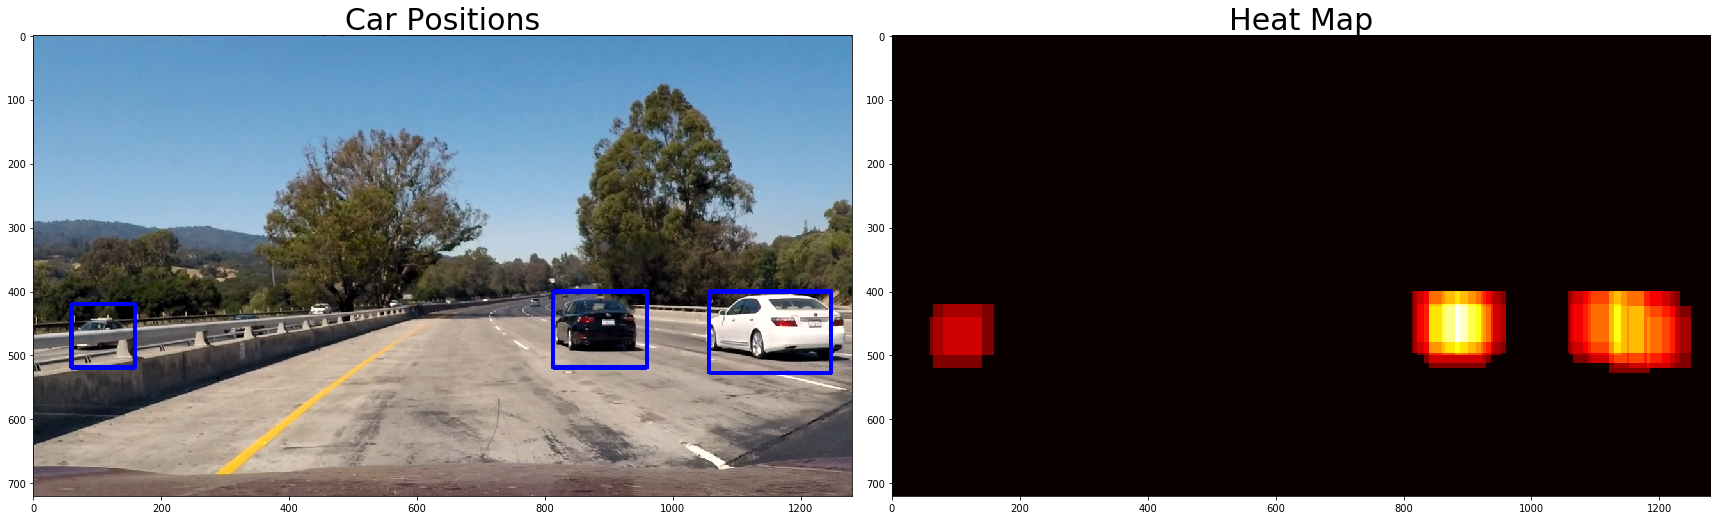

In [29]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

scales = [1.25, 1.5, 1.75, 2.0]

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_car_boxes(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox_list = []
    # make a copy of the image
    draw_img = np.copy(img)
    # scale the image to [0,1]
    img = img.astype(np.float32)/255
    
    # restrict the image search area
    img_tosearch = img[ystart:ystop,:,:]
    # convert the image search area to YCrCb
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    # if scale is not 1 shrink the search area by scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # split the search area into channels    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return bbox_list

for img in test_imgs:
    full_box_list = []
    for scale in scales:
        box_list = find_car_boxes(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        full_box_list.extend(box_list)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,full_box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure(figsize=(24, 9))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions', fontsize=30)
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map', fontsize=30)
    fig.tight_layout()

We first apply our pipeline to a short test video.

In [30]:
from moviepy.editor import VideoFileClip

def process_image(img):
    full_box_list = []
    for scale in scales:
        box_list = find_car_boxes(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        full_box_list.extend(box_list)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,full_box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
    
white_output = './test_video_final_result.mp4'
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./test_video_final_result.mp4
[MoviePy] Writing video ./test_video_final_result.mp4


 97%|█████████▋| 38/39 [00:50<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_final_result.mp4 

CPU times: user 50.5 s, sys: 760 ms, total: 51.2 s
Wall time: 52.5 s


And them to a final project video as well as the final result video from the project 4.

In [31]:
white_output = './project_video_final_result.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_final_result.mp4
[MoviePy] Writing video ./project_video_final_result.mp4


100%|█████████▉| 1260/1261 [25:39<00:01,  1.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_final_result.mp4 

CPU times: user 25min 31s, sys: 15.9 s, total: 25min 47s
Wall time: 25min 40s


In [32]:
white_output = './project_video_lanes_final_result.mp4'
clip1 = VideoFileClip("./project_video_lanes.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_lanes_final_result.mp4
[MoviePy] Writing video ./project_video_lanes_final_result.mp4


100%|█████████▉| 1260/1261 [25:25<00:01,  1.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_lanes_final_result.mp4 

CPU times: user 25min 20s, sys: 13.9 s, total: 25min 34s
Wall time: 25min 26s


## Discussion
Overall there were relatively few problems with this project. There were several points of optimization: selecting the good parameters for the HOG feature extractor, selecting the right color space, spatial and histogram bin size. Also the number of scales at which to search for cars and the numeric values for these scales were also a subject to tuning. The last parameter to tune was the number of bounding box intersections. The major issue was the amound of time it took to apply the pipeline to a full final video, which took anywhere from 25 to 40 minutes depending mostly on the settings for the HOG extractor. We found that with the current settings it was not necessary to do filtering for false positives among multiple subsequent frames. 

From scouting other solutions, looks like YOLO and YOLO9000 follow up algorithm far exceed the pipeline described here in performance and quality of identification and probably would be preferable for real-time real-life applications.

To improve on a pipeline described here, it maybe a good idea to add images from GTI and KITI and Udacity datasets to improve the accuracy of identification.